# Practicing loss functions and regression metrics

Below you will practice looking at loss functions and look at regression metrics related to these loss functions.

---

## 1. Load packages

In [26]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error

%matplotlib inline

---

## 2. Plotting functions

Here are the functions from the presentation to make visualizing your regressions easier:

In [2]:
def plot_regression(x, y, model):
    plt.figure(figsize=(10,8))
    axes = plt.gca()
    
    intercept = model.params[0]
    slope = model.params[1]

    for x_, y_ in zip(x, y):    
        plt.plot((x_, x_), (y_, x_*slope + intercept),
                 'k-', ls='dashed', lw=1)
        
    plt.scatter(x, y, s=70, c='steelblue')
    
    x_points = np.linspace(axes.get_xlim()[0], axes.get_xlim()[1], 100)
    
    regline_x = x_points
    regline_y = x_points*slope + intercept

    plt.plot(regline_x, regline_y, c='darkred', lw=3.5)

    plt.show()
    
    
def plot_leastsq_loss(model):
    plt.figure(figsize=(10,8))
    
    resids = model.resid
    
    resid_lim = np.max([abs(np.min(resids)), abs(np.max(resids))]) + 1
    
    resid_points = np.linspace(-1*resid_lim, resid_lim, 200)
    
    for r in resids:
        plt.plot((r, r), (0, r**2), 'k-', ls='dashed', lw=2)
        
    plt.plot(resid_points, resid_points**2, c='gold', alpha=0.7)
    

def plot_residuals_ladloss(model):
    
    resids = model.resid
    
    resid_lim = np.max([abs(np.min(resids)), abs(np.max(resids))]) + 1
    
    resid_points = np.linspace(-1*resid_lim, resid_lim, 200)
    
    plt.figure(figsize=(10,8))
    
    for r in resids:
        
        plt.plot((r, r), (0, abs(r)), 'k-', ls='dashed', lw=1)
        
    plt.plot(resid_points, np.abs(resid_points), c='gold', alpha=0.7)
    


---

## 3. Load in the data from project 3

Load your data from project 3. Below is the small version I put in datasets, but if you've worked on it and have it cleaned you may want to load your version instead.

In [3]:
# here is the small version i put in your datasets folder:
iowa = pd.read_csv('/Users/ryandunlap/Desktop/DSI-SF-2/datasets/iowa_liquor/Iowa_Liquor_sales_sample_10pct.csv')

---

## 4. Choose a continuous response variable and predictor variable from the dataset

If you choose columns with dollar amounts, you will need to remove the dollar signs!

In [20]:
iowa.iloc[np.random.choice(iowa.index,int(iowa.size*0.0001)),:]

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
129020,12/17/2015,2587,JOHNSTON,50131,77.0,Polk,1012100.0,CANADIAN WHISKIES,260,11290,Crown Royal Canadian Whisky Mini,300,$7.35,$11.03,4,$44.12,1.20,0.32
180485,03/18/2015,2623,SIOUX CITY,51104,97.0,Woodbury,1081390.0,IMPORTED SCHNAPPS,260,69947,Rumple Minze Peppermint Schnapps Liqueur,1000,$15.75,$23.63,24,$567.12,24.00,6.34
161801,10/22/2015,4140,DES MOINES,50313,77.0,Polk,1081600.0,WHISKEY LIQUEUR,421,64864,Fireball Cinnamon Whisky,375,$5.33,$8.00,24,$192.00,9.00,2.38
1713,02/18/2015,3970,NEVADA,50201,85.0,Story,1011200.0,STRAIGHT BOURBON WHISKIES,421,16517,Ancient Age Bourbon,1000,$7.50,$11.25,4,$45.00,4.00,1.06
102254,01/05/2016,4255,ORANGE CITY,51041,84.0,Sioux,1012100.0,CANADIAN WHISKIES,260,11294,Crown Royal Canadian Whisky,375,$7.75,$11.63,2,$23.26,0.75,0.20
25891,03/02/2015,2569,CEDAR RAPIDS,52402,57.0,Linn,1032200.0,IMPORTED VODKA - MISC,370,34076,Absolut Vanilia,750,$11.49,$17.24,3,$51.72,2.25,0.59
113038,12/29/2015,4879,SIOUX CITY,51106,97.0,Woodbury,1031100.0,100 PROOF VODKA,300,36908,Mccormick Vodka Pet,1750,$7.47,$11.21,12,$134.52,21.00,5.55
79003,09/29/2015,2565,SPENCER,51301,21.0,Clay,1081330.0,PEACH SCHNAPPS,434,82127,Arrow Peach Schnapps,1000,$5.00,$7.50,4,$30.00,4.00,1.06
212278,02/25/2016,2561,DES MOINES,50321,77.0,Polk,1031080.0,VODKA 80 PROOF,55,35314,Barton Vodka,375,$1.71,$2.57,24,$61.68,9.00,2.38
198647,04/29/2015,2572,CEDAR FALLS,50613,7.0,Black Hawk,1081600.0,WHISKEY LIQUEUR,421,64864,Fireball Cinnamon Whisky,375,$5.33,$8.00,4,$32.00,1.50,0.40


---

## 5. Choose a small subset of the predictor and response variables you chose

You can use the ```np.random.choice()``` function to get a random sample of indices. Look up how to use it!

In [24]:
#iowa.iloc[np.random.choice(iowa.index,int(iowa.size*0.0001)),:]
iowa_train = iowa.iloc[np.random.choice(iowa.index,1000),:]

---

## 6. Build a least squares regression model predicting your response from your predictors

For this one use statsmodels rather than sklearn.

I did not provide the code to create the regression. Either look it up in the statsmodels documentation or refer to the slides so you can practice doing this yourself.

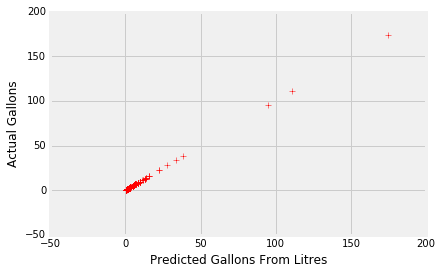

MSE: 9.36983022638e-06


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Volume Sold (Gallons)   R-squared:                       1.000
Model:                               OLS   Adj. R-squared:                  1.000
Method:                    Least Squares   F-statistic:                 6.887e+09
Date:                   Tue, 09 Aug 2016   Prob (F-statistic):               0.00
Time:                           12:22:40   Log-Likelihood:                 4370.1
No. Observations:                   1000   AIC:                            -8738.
Df Residuals:                        999   BIC:                            -8733.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Volume Sold (Liters)     0.2642   3.18e-06    8.3e+04      0.000         0.264     0.264
==============================================================================
Omnibus:                       12.282   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               97.659
Skew:                          -0.274   Prob(JB):                     6.22e-22
Kurtosis:                       1.571   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
import statsmodels.api as sm

X = iowa_train[['Volume Sold (Liters)']]
y = iowa_train["Volume Sold (Gallons)"]

model = sm.OLS(y,X).fit()
predictions = model.predict(X)

# Plot the model
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Gallons From Litres")
plt.ylabel("Actual Gallons")
plt.show()

print "MSE:", mean_squared_error(y, predictions)
model.summary()

---

## 7. Plot the least squares regression

You can use the ```plot_regression(x, y, model)``` function provided.

---

## 8. Build a least absolute deviation quantreg model on the same sample

---

## 9. Plot the LAD regression

---

## 10. Calculate the RMSE and the MAE between you response and predicted response

**RMSE** is the **root mean squared error**. It is a metric for the performance of your regression related to the least squared loss. 

$$\text{RMSE} = \sqrt{\frac{\sum_{i}{\left(\hat{y}_i - y_i \right)^2}}{n}}$$

https://en.wikipedia.org/wiki/Root-mean-square_deviation

**MAE** is the **mean absolute error**. It is a metric for regression performace when the loss function is the least absolute deviation.

$$\text{MAE} = \frac{\sum_{i}{|\hat{y}_i - y_i |}}{n}$$

https://en.wikipedia.org/wiki/Average_absolute_deviation

In [4]:
## RMSE:

In [5]:
## MAE:

---

## 11. [Challenge] What would be the loss function to find the _mode_ and why?

Remember that the least squares loss minimizes:

### $$\sum_{i}{\left(\hat{y}_i - y_i \right)^2}$$

And the least absolute deviation loss minimizes:

### $$y = \sum_{i}{|\hat{y}_i - y_i |^1}$$

**Do you see a pattern here?**


In [6]:
#

---

## 12. Create a quantile regression with q = 0.25 and plot it. What exactly is this regression predicting?